# Необходимые функции и библиотеки

In [1]:
import numpy as np
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.datasets import make_regression

# графики
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def make_data(target_func, factors, number_of_points, start_time=0, finish_time=5, shuffle=False, smooth=False):
    """
    Функция для генерации данных
    
    Parameters:
        target_func : (func)
            целевая функция
        factors : (func)
            значения вектора регрессора
        number_of_points : (int)
            число наблюдений, которое надо сгенерировать
        start_time : (float, default=0)
            нижняя граница времени
        finish_time : (float, default=5)
            верхняя граница времени
        shuffle : (bool, default=False)
            в случае True данные будут перемешаны
        smooth : (bool, default=False)
            в случае True данные будут зашумлены (гауссовским шумом)
    
    Return:
        X (numpy.array) : выборка (признаки, значения регрессора в разные моменты времени)
        y (numpy.array) : выборка (целевое значение в разные моменты времени)
    
    """
    time_interval = np.linspace(start_time, finish_time, number_of_points)
    X = np.array([factors(t) for t in time_interval])
    y = np.array([target_func(t) for t in time_interval])
    
    if smooth:
        noise = np.random.normal(0, 1, number_of_points)
        y += noise
    
    if shuffle:
        indexes_for_shuffle = np.arange(len(y))
        np.random.shuffle(indexes_for_shuffle)
        X = X[indexes_for_shuffle]
        y = y[indexes_for_shuffle]
    
    return X, y

# Класс модели, использующей метод динамического расширения и смешивания регрессора

In [3]:
class DREM_model:
    """
    Регрессионная модель, основанная на методе динамического расширения и смешивания регрессора
    
    Parameters:
        lr (float) : коэффициент адаптации
        eps (float) : точность сходимости
        number_of_iter (int) : количество итераций
    
    Methods:
        fit(X: numpy.array, y: numpy.array) : 
                вычисление параметров регрессионной модели
    Notes:
        Для оценивания параметров используется итерационная процедура:
            W(k+1) = W(k) + (lr*det(X)) / (1 + lr*det(X)*det(X)) * (adj(X)*y - det(X)*W(k)) (при len(X)==число признаков)
            W(k+1) = W(k) + intercept/s (при len(X)== (s * число признаков))
            здесь intercept = sum((lr*det(X_i)) / (1 + lr*det(X_i)*det(X_i)) * (adj(X_i)*y_i - det(X_i)*W(k))) для каждой i-ой части (i=1,s)
    """
    def __init__(self, lr, number_of_iter=100000, eps=0.000001):
        self.theta = np.array([])
        self.scores_results = []
        
        self.eps = eps
        self.lr = lr
        self.n_of_iter = number_of_iter
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.theta = np.zeros(n_features)
        
        if n_samples % n_features == 0:
            indexes_for_shuffle = np.arange(len(y))
            np.random.shuffle(indexes_for_shuffle)
            X = X[indexes_for_shuffle]
            y = y[indexes_for_shuffle]
            
            n_batches = n_samples // n_features
            X_shaped = X.reshape(n_batches, n_features, n_features)
            y_shaped = y.reshape(n_batches, n_features)
            
            intercept_of_theta = 0
            for i in range(3*self.n_of_iter):
                patch = i % n_batches
                X_train = X_shaped[patch]
                y_train = y_shaped[patch]
                
                det, inv = np.linalg.det(X_train), np.linalg.pinv(X_train)
                
                left = det * inv.dot(y_train) 
                
                normalize_coef = (self.lr * det)/(1 + self.lr * det**2)
                error = left - det * self.theta
                intercept_of_theta += normalize_coef * error
                
                if i>0 and patch==0:
                    self.theta = self.theta + intercept_of_theta/n_batches
                    intercept_of_theta = 0
                    self.scores_results.append(self.score(X, y))
                    
        else:
            for i in range(self.n_of_iter):
                ##
                indexes = np.random.choice(n_samples, size=n_features)
                X_train = X[indexes]
                y_train = y[indexes]
                det, inv = np.linalg.det(X_train), np.linalg.pinv(X_train)
                left = det * inv.dot(y_train) 
                ##
                normalize_coef = (self.lr * det)/(1 + self.lr * det**2)
                error = left - det * self.theta
                
                
                self.theta = self.theta + normalize_coef * error
                
                ##
                self.scores_results.append(self.score(X, y))
                
    def predict(self, X):
        return X.dot(self.theta)
    
    @property
    def coef_(self):
        return self.theta
    
    def score(self, X, y):
        predicted = self.predict(X)
        r2 = 1 - np.sum((predicted-y)**2)/np.sum((y-y.mean())**2)
        return r2

# Сравниваемые модели

In [4]:
model_ols = LinearRegression()
model_grad = SGDRegressor()
model_drem = DREM_model(lr=0.001, number_of_iter=100000)

# Набор данных

In [5]:
#  регрессор 
regressor = lambda t: np.array([np.sin(0.1*t + np.pi/3),
                                np.sin(3*t + np.pi/2),
                                np.sin(5*t)])
#  целевая функция
target = lambda t: 2 * np.sin(0.1*t + np.pi/3) + 1 * np.sin(3*t + np.pi/2) - 3 * np.sin(5*t)

full_time_interval = np.linspace(0, 500, 50000)

## Без шума

In [6]:
# 50 000 наблюдений: t от 0 до 15 секунд с шагом 0.01
X_full, y_full = make_data(target,
                           regressor,
                           number_of_points=50000,
                           start_time=0,
                           finish_time=500,
                           smooth=False,
                           shuffle=True)

# 500 раз произведем оценивание параметров (в разные промежутки времени)
X_shaped = X_full.reshape(500, 100, 3)
y_shaped = y_full.reshape(500, 100)

## С шумом

In [7]:
# 50 000 наблюдений: t от 0 до 500 секунд с шагом 0.01
X_full_smooth, y_full_smooth = make_data(target,
                                         regressor,
                                         number_of_points=50000,
                                         start_time=0,
                                         finish_time=500,
                                         smooth=True,
                                         shuffle=True)

# 500 раз произведем оценивание параметров (в разные промежутки времени)
X_shaped_smooth = X_full_smooth.reshape(500, 100, 3)
y_shaped_smooth = y_full_smooth.reshape(500, 100)

# Эксперимент

In [8]:
dict_with_results = {'DREM': [], 'Gradient Descent': [], 'Least Squares': []}
dict_with_estimation = {'DREM': [], 'Gradient Descent': [], 'Least Squares': []}
dict_with_score = {'DREM': [], 'Gradient Descent': [], 'Least Squares': []}

## На "чистом" наборе

In [9]:
for name, model in [('Least Squares', model_ols), ('Gradient Descent', model_grad), ('DREM', model_drem)]:
    for i in range(500):
        X_patch = X_shaped[i]
        y_patch = y_shaped[i]
        
        model.fit(X_patch, y_patch)
        dict_with_estimation[name].append(model.coef_)
        dict_with_results[name] += model.predict(X_patch).tolist()

Text(0, 0.5, 'Зависимая переменная y(t)')

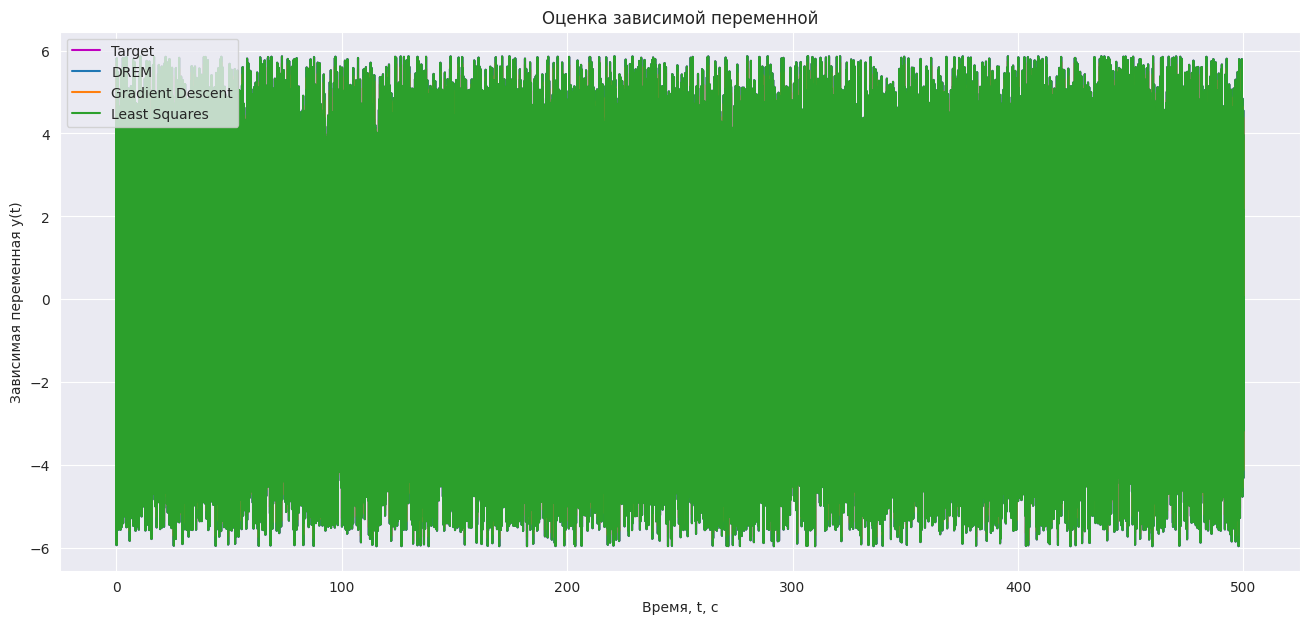

In [10]:
plt.figure(figsize=(16, 7))
plt.plot(full_time_interval, y_full, c='m', label='Target')

for model in dict_with_results:
    plt.plot(full_time_interval, dict_with_results[model], label=model)
    
plt.title('Оценка зависимой переменной')
plt.legend()
plt.xlabel('Время, t, с')
plt.ylabel('Зависимая переменная y(t)')

In [11]:
for model in dict_with_estimation:
    dict_with_estimation[model] = np.vstack(dict_with_estimation[model])

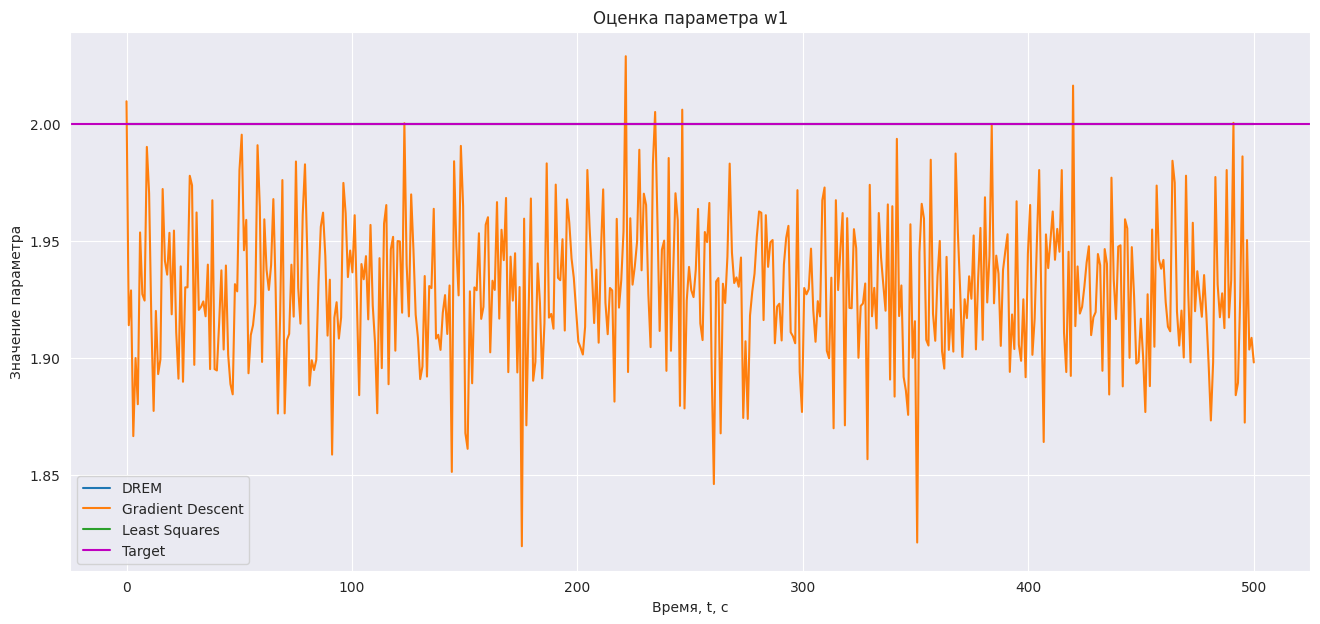

In [12]:
plt.figure(figsize=(16, 7))

for model in dict_with_results:
    plt.plot(np.linspace(0, 500, 500), dict_with_estimation[model][:, 0], label=model)
    
plt.axhline(y=2, xmin=0, xmax=5, c='m', label='Target')
plt.title('Оценка параметра w1')
plt.xlabel('Время, t, с')
plt.ylabel('Значение параметра')
plt.legend()

In [ ]:
plt.figure(figsize=(16, 7))

for model in dict_with_results:
    plt.plot(np.linspace(0, 500, 500), dict_with_estimation[model][:, 1], label=model)
    
plt.axhline(y=1, xmin=0, xmax=5, c='m', label='Target')
plt.title('Оценка параметра w2')
plt.xlabel('Время, t, с')
plt.ylabel('Знаение параметра')
plt.legend()

In [ ]:
plt.figure(figsize=(16, 7))

for model in dict_with_results:
    plt.plot(np.linspace(0, 500, 500), dict_with_estimation[model][:, 2], label=model)
    
plt.axhline(y=-3, xmin=0, xmax=5, c='m', label='Target')
plt.title('Оценка параметра w3')
plt.xlabel('Время, t, с')
plt.ylabel('Значение параметра')
plt.legend()

## На зашумленном наборе

In [15]:
dict_with_results = {'DREM': [], 'Gradient Descent': [], 'Least Squares': []}
dict_with_estimation = {'DREM': [], 'Gradient Descent': [], 'Least Squares': []}
dict_with_score = {'DREM': [], 'Gradient Descent': [], 'Least Squares': []}

In [ ]:
for name, model in [('Least Squares', model_ols), ('Gradient Descent', model_grad), ('DREM', model_drem)]:
    for i in range(500):
        X_patch = X_shaped_smooth[i]
        y_patch = y_shaped_smooth[i]
        if i > 1:
            dict_with_score[name].append(model.score(X_patch, y_patch))
        
        
        model.fit(X_patch, y_patch)
        dict_with_estimation[name].append(model.coef_)
        dict_with_results[name] += model.predict(X_patch).tolist()

In [ ]:
plt.figure(figsize=(16, 7))
plt.plot(full_time_interval, y_full, c='m', label='Target')

for model in dict_with_results:
    plt.plot(full_time_interval, dict_with_results[model], label=model)
    
plt.title('Оценка зависимой переменной')
plt.legend()
plt.xlabel('Время, t, с')
plt.ylabel('Зависимая переменная y(t)')

In [ ]:
plt.figure(figsize=(16, 7))
plt.plot(full_time_interval[:500], y_full[:500], c='m', label='Target')

for model in dict_with_results:
    plt.plot(full_time_interval[:500], dict_with_results[model][:500], label=model)
    
plt.title('Оценка зависимой переменной')
plt.legend()
plt.xlabel('Время, t, с')
plt.ylabel('Зависимая переменная y(t)')

In [ ]:
for model in dict_with_estimation:
    dict_with_estimation[model] = np.vstack(dict_with_estimation[model])

In [ ]:
plt.figure(figsize=(16, 7))

for model in dict_with_results:
    plt.plot(np.linspace(0, 500, 500), dict_with_estimation[model][:, 0], label=model)
    
plt.axhline(y=2, xmin=0, xmax=500, c='m', label='Target')
plt.title('Оценка параметра theta1')
plt.xlabel('Время, t, с')
plt.ylabel('Значение параметра')
plt.legend()

In [ ]:
plt.figure(figsize=(16, 7))

for model in dict_with_results:
    plt.plot(np.linspace(0, 150, 150), dict_with_estimation[model][:, 1][:150], label=model)
    
plt.axhline(y=1, xmin=0, xmax=150, c='m', label='Target')
plt.title('Оценка параметра theta2')
plt.xlabel('Время, t, с')
plt.ylabel('Значение параметра')
plt.legend()

In [ ]:
plt.figure(figsize=(16, 7))

for model in dict_with_results:
    plt.plot(np.linspace(0, 500, 500), dict_with_estimation[model][:, 2], label=model)
    
plt.axhline(y=-3, xmin=0, xmax=500, c='m', label='Target')
plt.title('Оценка параметра theta3')
plt.xlabel('Время, t, с')
plt.ylabel('Значение параметра')
plt.legend()

In [ ]:
plt.figure(figsize=(16, 7))


for model in dict_with_score:
    plt.plot(np.linspace(2, 50, 48), dict_with_score[model][:48], label=model)
    
plt.title('Качества моделей в разные моменты времени')
plt.legend()
plt.xlabel('Время, t, с')
plt.ylabel('R^2')